# Monte-carlo simulations

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot, plot_parameters
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
plt.style.use('presentation')

from myst_nb import glue
from wPCC_pipeline.paper import glue_table
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmm_names = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)

ship_data = catalog.load("ship_data")

UsageError: Line magic function `%reload_kedro` not found.


In [2]:
from sympy import latex
from scipy.stats import norm, multivariate_normal
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
import tqdm
import sys
from wPCC_pipeline.turning_circle import TurningCircle
import seaborn as sns

In [9]:
#vmm_name = 'vmm_abkowitz_simple'
vmm_name = 'vmm_martins_simple'
#vmm_name = 'vmm_abkowitz'


model = catalog.load(f"{ vmm_name }.motion_regression.joined.model")
ek = catalog.load(f"{ vmm_name }.ek")

id = 22774
regression = catalog.load(f"{ vmm_name }.motion_regression.no_circle.regression")
df_smooth = catalog.load(f"{ id }.data_ek_smooth")

2022-03-28 17:29:58,289 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.model` (PickleDataSet)...
2022-03-28 17:29:58,295 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.ek` (ExtendedKalmanDataSet)...
2022-03-28 17:29:58,299 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.no_circle.regression` (PickleDataSet)...
2022-03-28 17:29:58,350 - kedro.io.data_catalog - INFO - Loading data from `22774.data_ek_smooth` (CSVDataSet)...


In [10]:
def monte_carlo(data_smooth, df_parameter_variation, model, ek):

    dataframes = {}
    with tqdm.tqdm(total=len(df_parameter_variation), file=sys.stdout) as pbar:
        for index, parameters_ in df_parameter_variation.iterrows():
            model_ = model.copy()
            model_.parameters.update(parameters_)
            
            df_ = simulate_euler(data=data_smooth, model=model_,ek=ek, solver='Radau') 
            dataframes[index] = df_
        
            pbar.update(1)
        
    return dataframes

In [18]:
means = regression.parameters['regressed']
stds = regression.std

cov = regression.covs.values

rv = multivariate_normal(mean=means, cov=cov, allow_singular=True)
np.random.seed(42)
N_=1000
df_parameter_variation = pd.DataFrame(data=rv.rvs(N_), columns=means.index)

In [19]:
dataframes = monte_carlo(df_smooth, df_parameter_variation, model=model, ek=ek)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:19<00:00,  1.10s/it]


In [ ]:
dataframes['model test'] = df_smooth
dataframes['VMM all'] = catalog.load(f"{ vmm_name }.motion_regression.joined.{ id }.data_resimulate")
dataframes['VMM circle hold out'] = catalog.load(f"{ vmm_name }.motion_regression.no_circle.{ id }.data_resimulate")

In [41]:
dataframes_ = dataframes.copy()
displays = []
displays.append({key:value for key,value in dataframes.items() if key not in ['model test', 'VMM all', 'VMM circle hold out']})
displays.append({key:value for key,value in dataframes.items() if key not in ['model test', 'VMM all']})
displays.append({key:value for key,value in dataframes.items() if key not in ['VMM all']})
displays.append(dataframes)

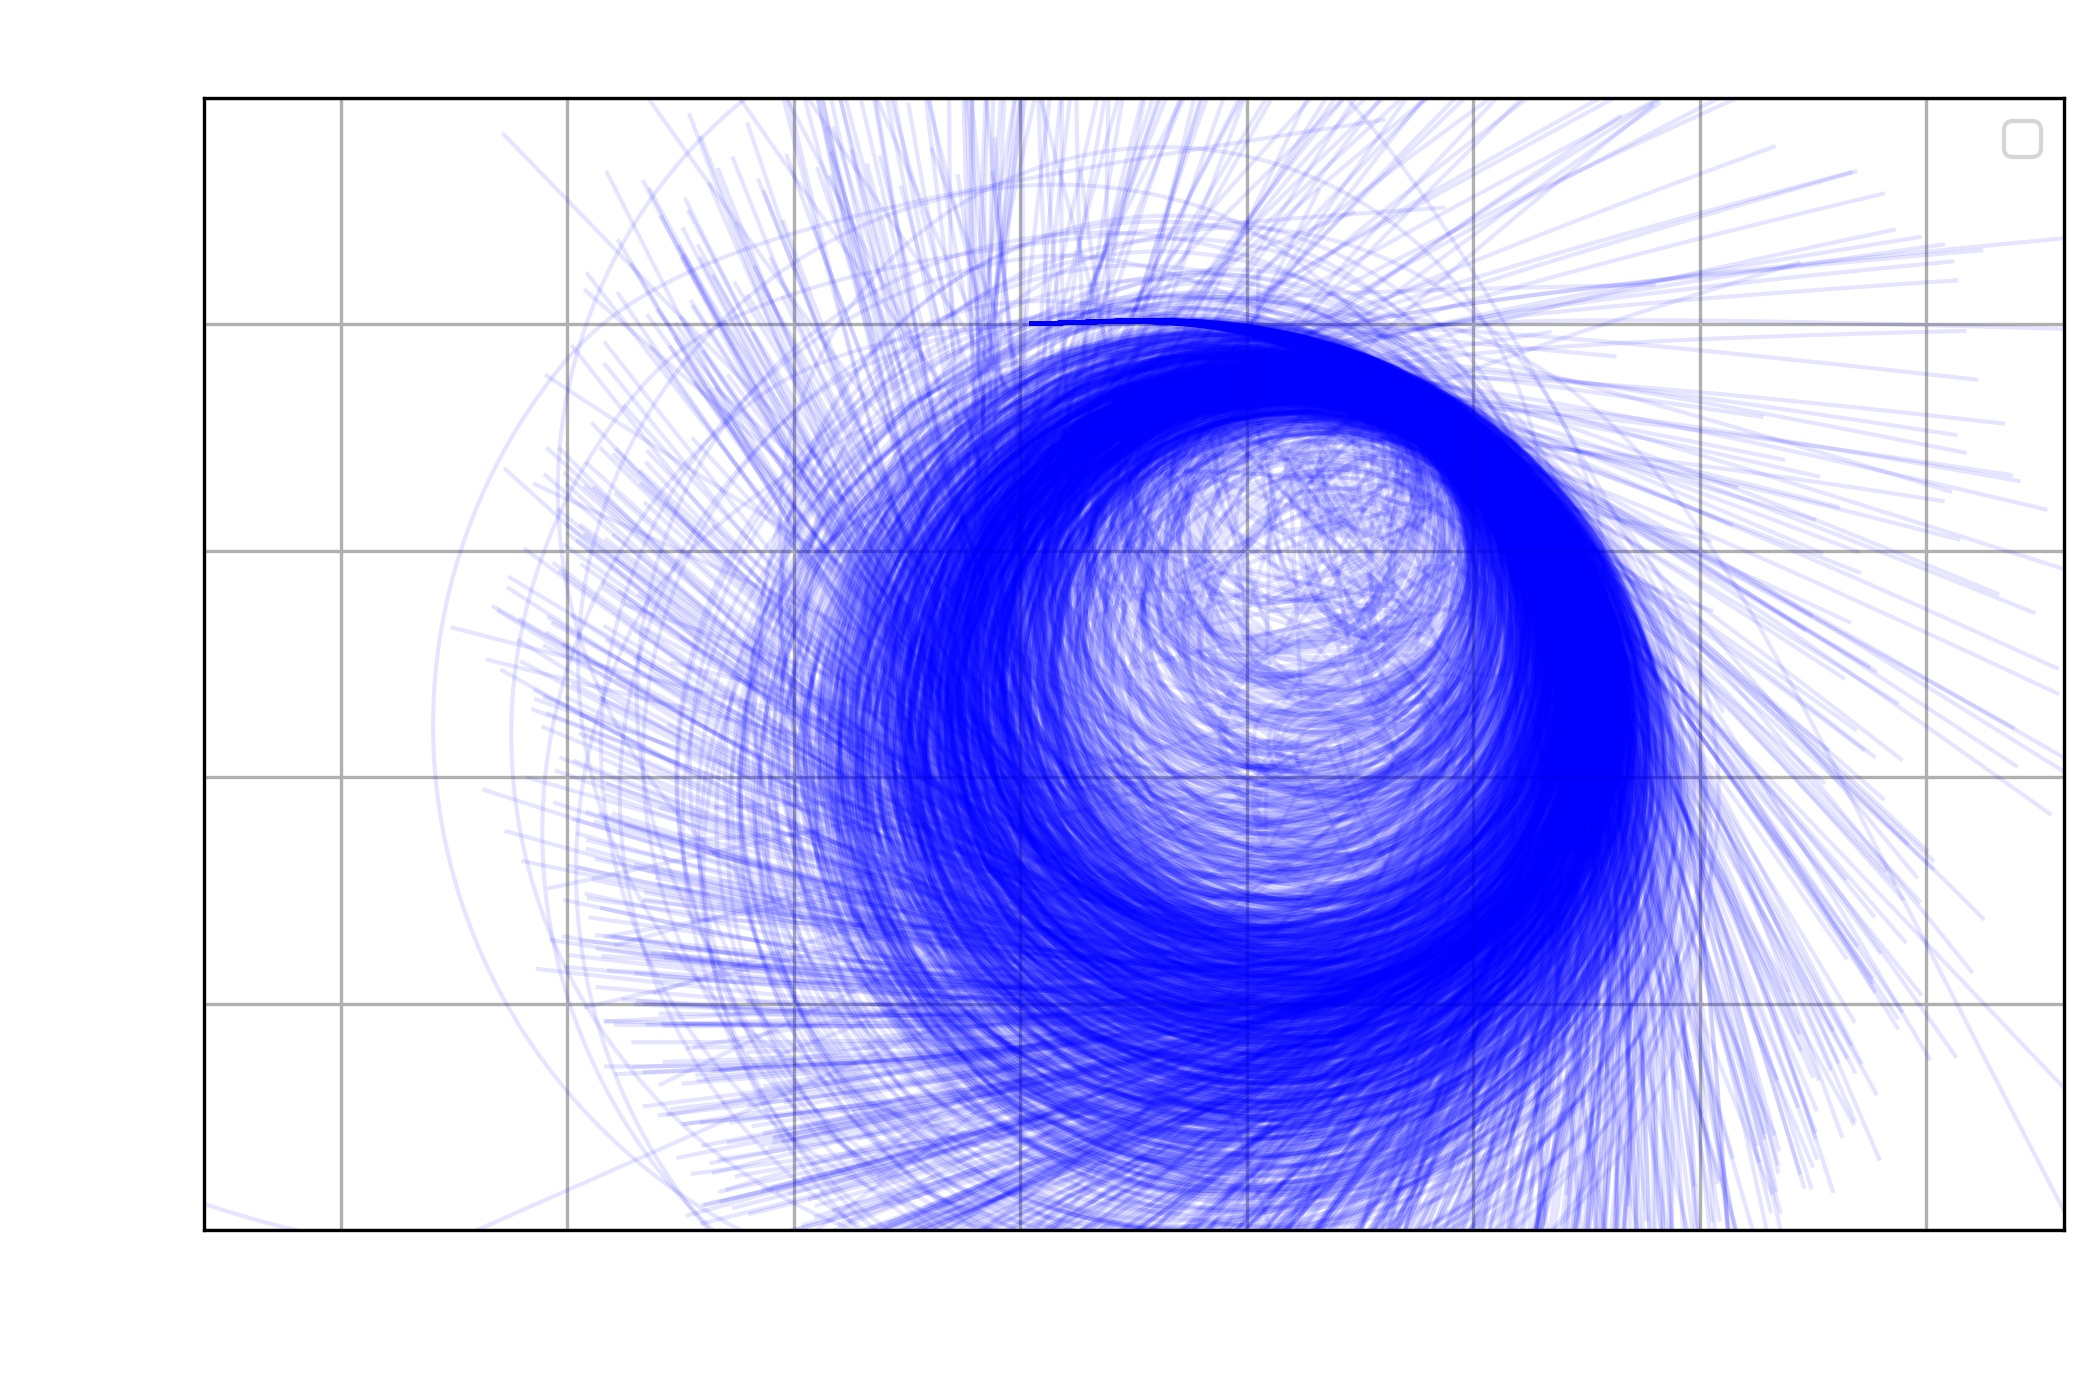

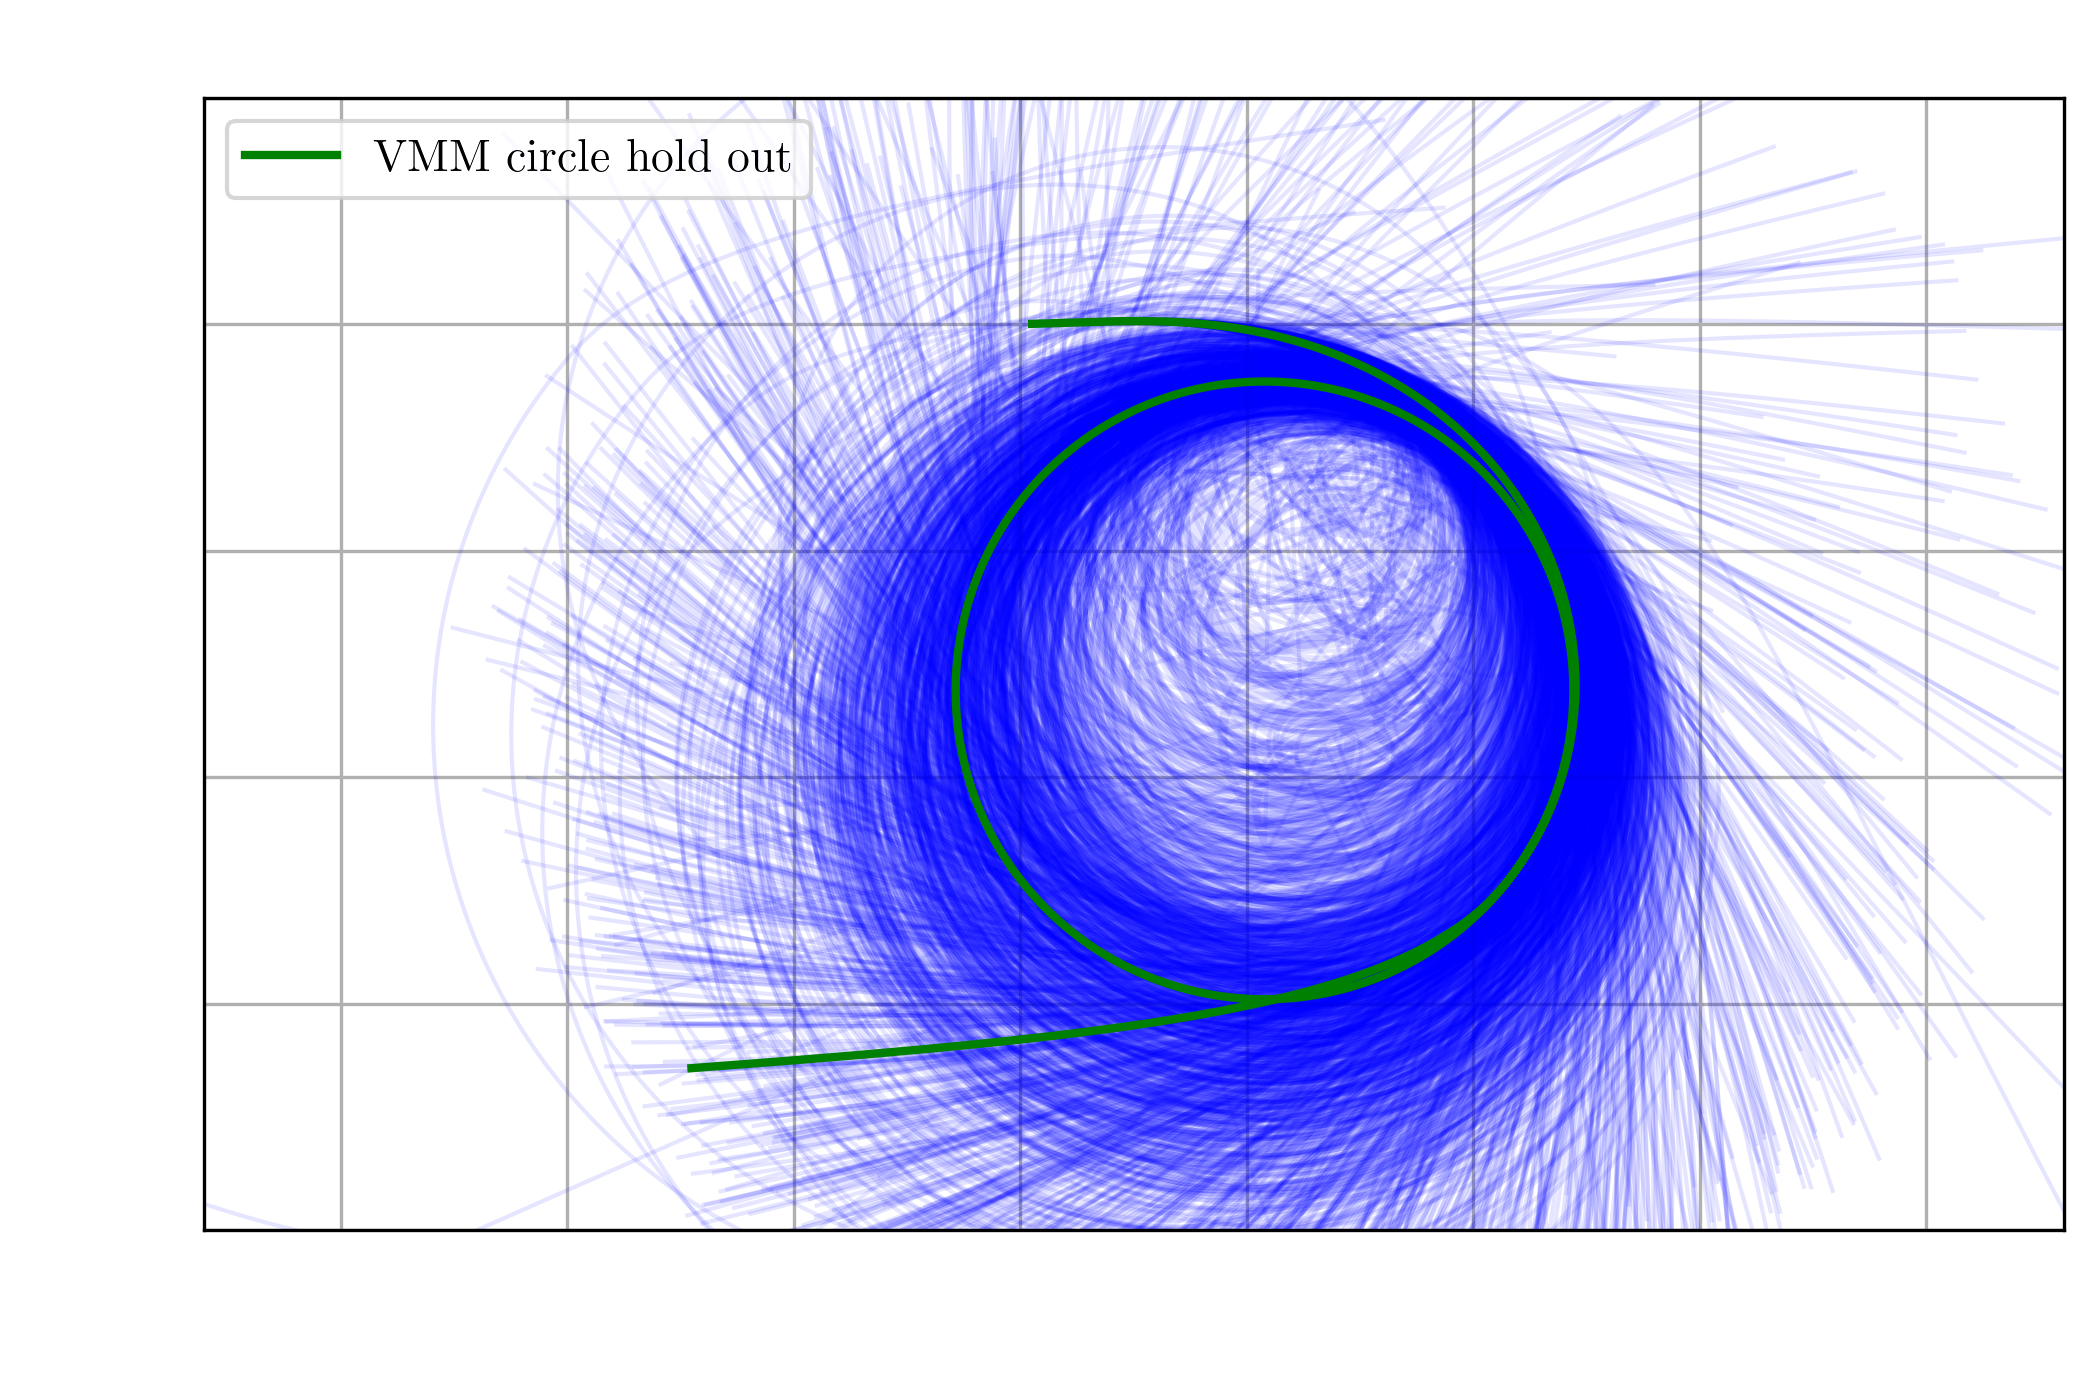

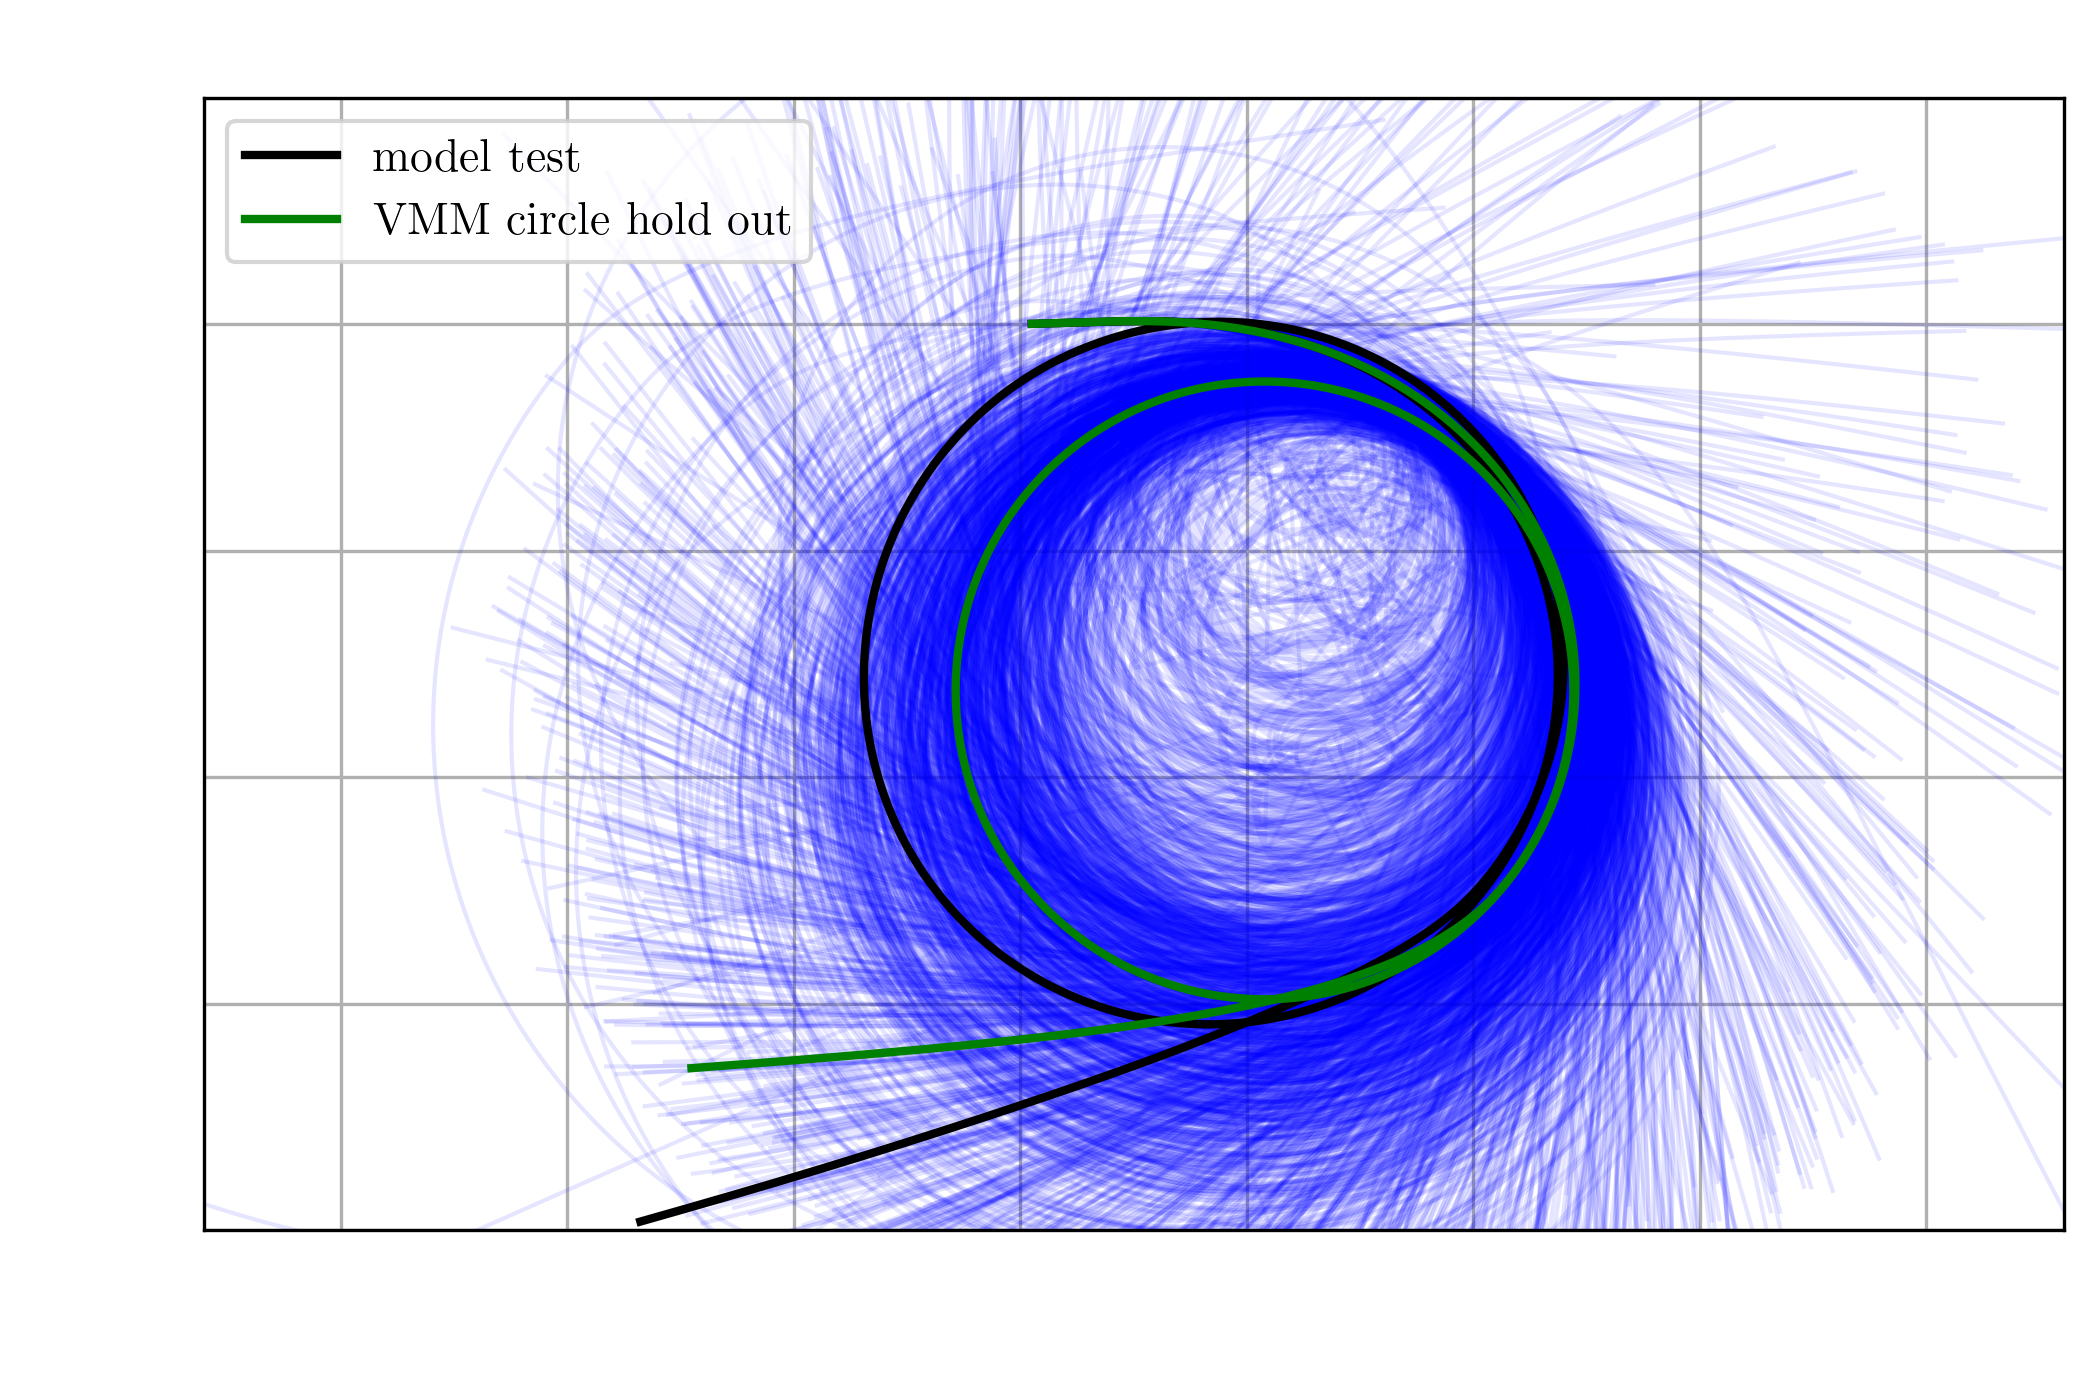

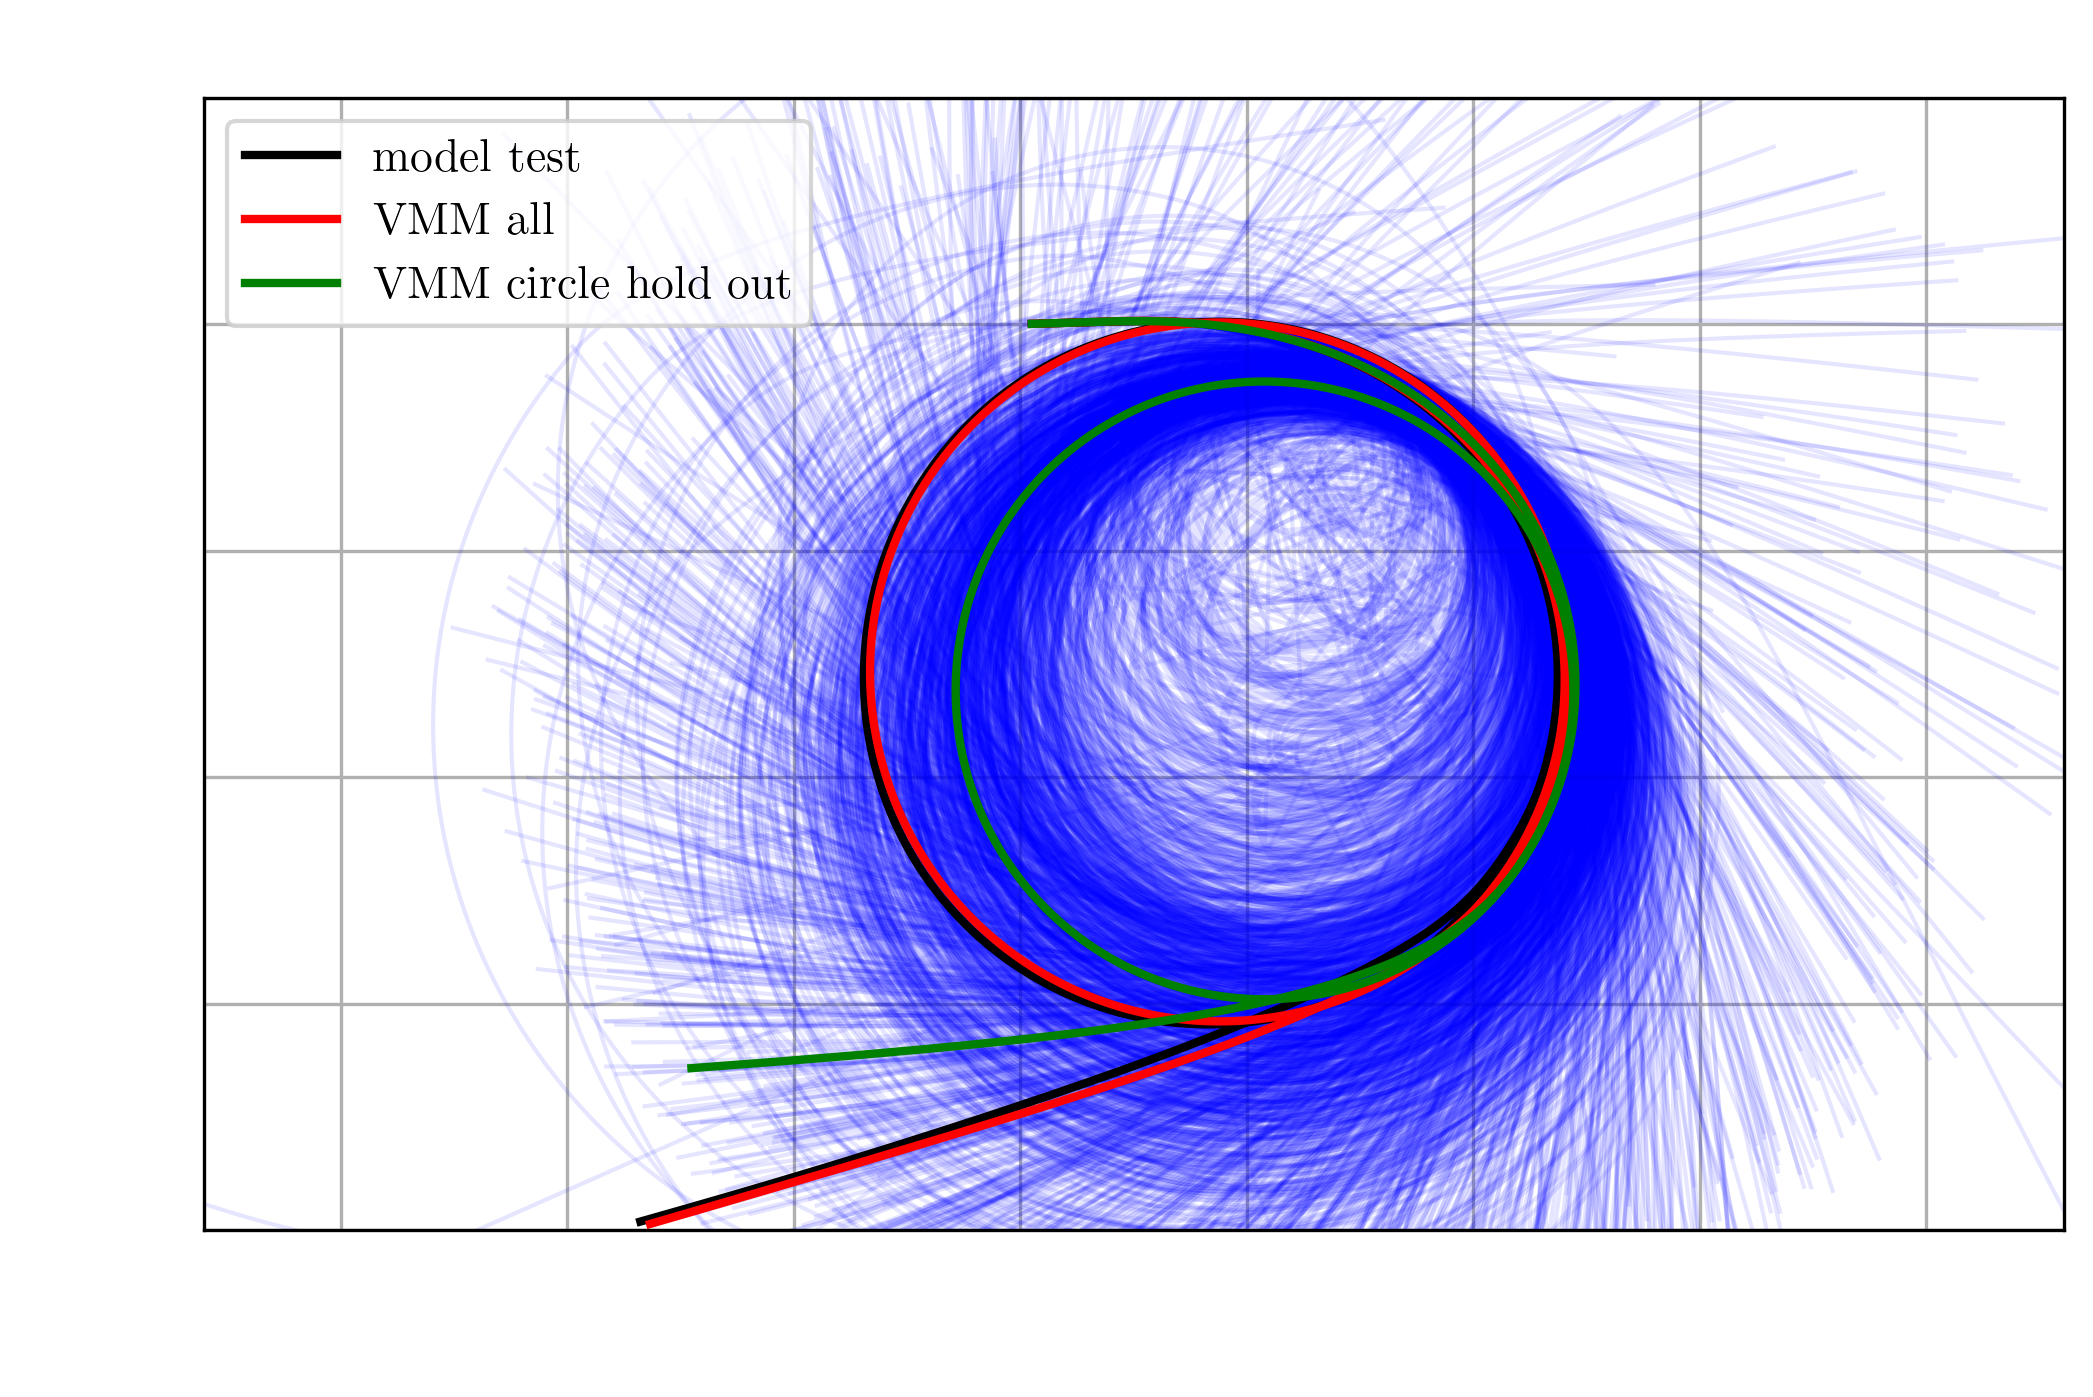

In [56]:


styles={'model test':{'style':'k-','lw':2},
       'VMM all':{'style':'r-','lw':2},
       'VMM circle hold out':{'style':'g-','lw':2},
        
       }

for index, parameters_ in df_parameter_variation.iterrows():
    styles[index] = {'style':'b-', 
                     'alpha':0.1,
                     'label':'_Hidden label'}

for dataframes_ in displays:
    fig,ax=plt.subplots()
    grid.fig.set_size_inches(0.7*np.array(matplotlib.rcParams["figure.figsize"]))
    
    ax = track_plots(dataframes_, lpp=ship_data['L'], beam=ship_data['B'], plot_boats=False, flip=True, N=7, styles=styles, ax=ax)
    ax.set_xlim(0,25)
    ax.set_ylim(-20,5)

In [53]:
df_turning_results = pd.DataFrame()

for name, df_ in dataframes.items():

    df_['V'] = np.sqrt(df_['u']**2 + df_['v']**2)
    turning_circle = TurningCircle(angle=35, nominal_speed=10, lpp=ship_data['L'], df=df_)
    res = pd.Series(turning_circle.evaluate(), name=name)
    df_turning_results = df_turning_results.append(res)

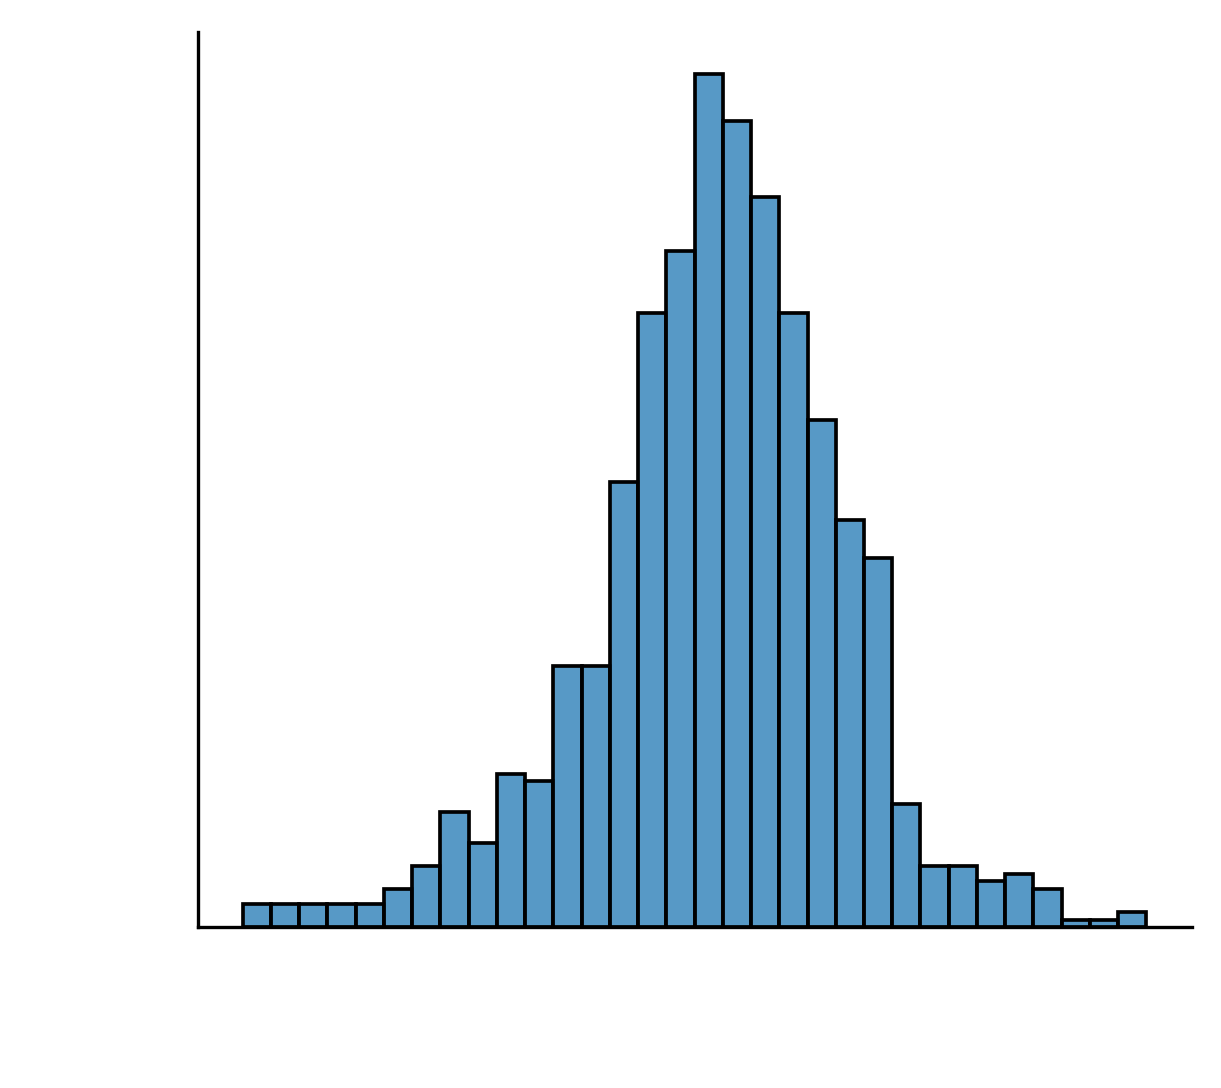

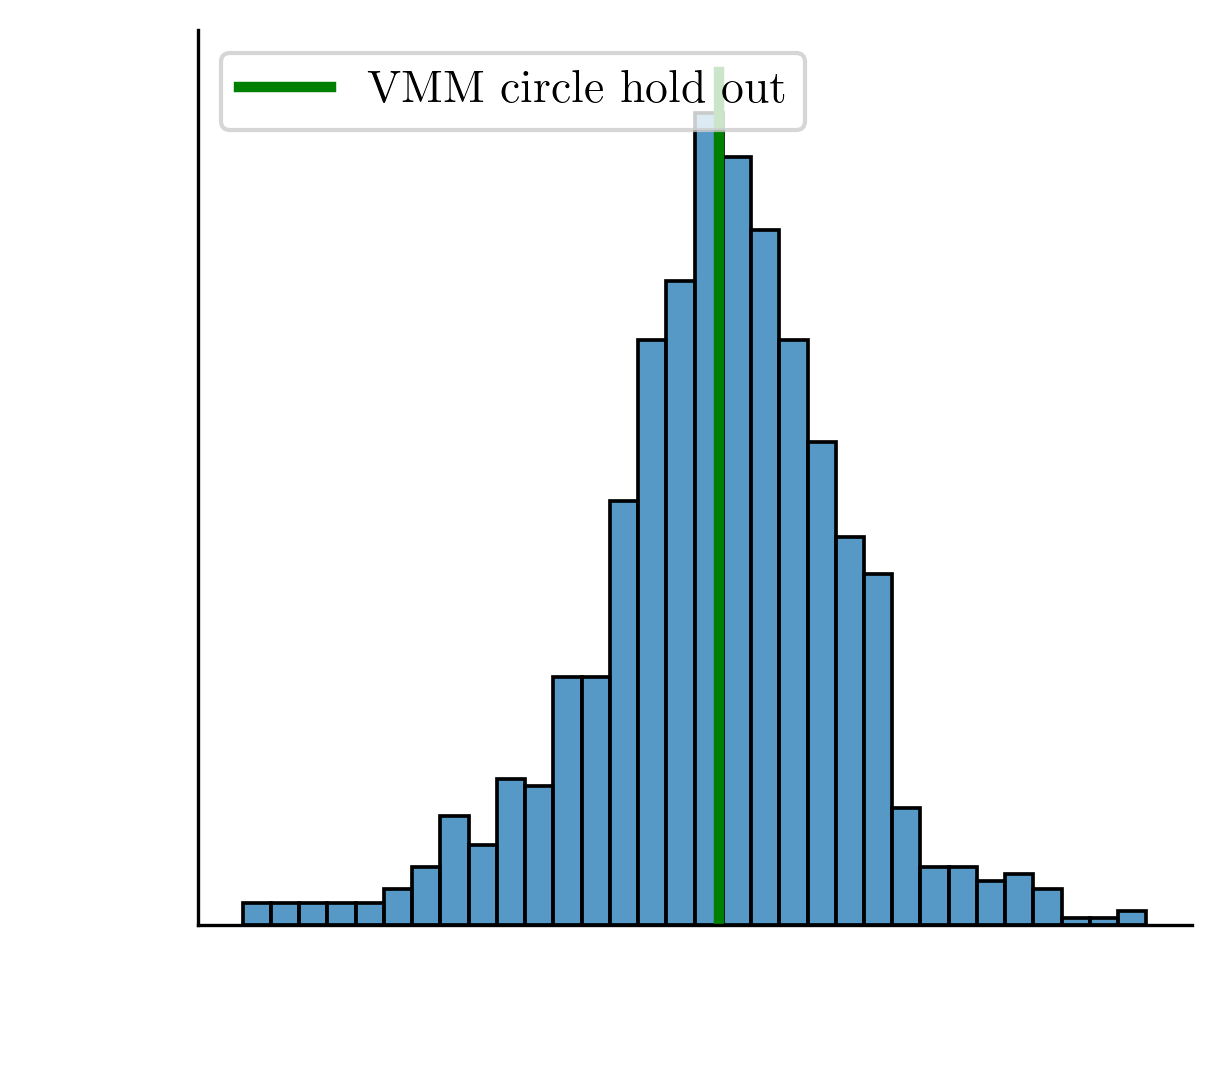

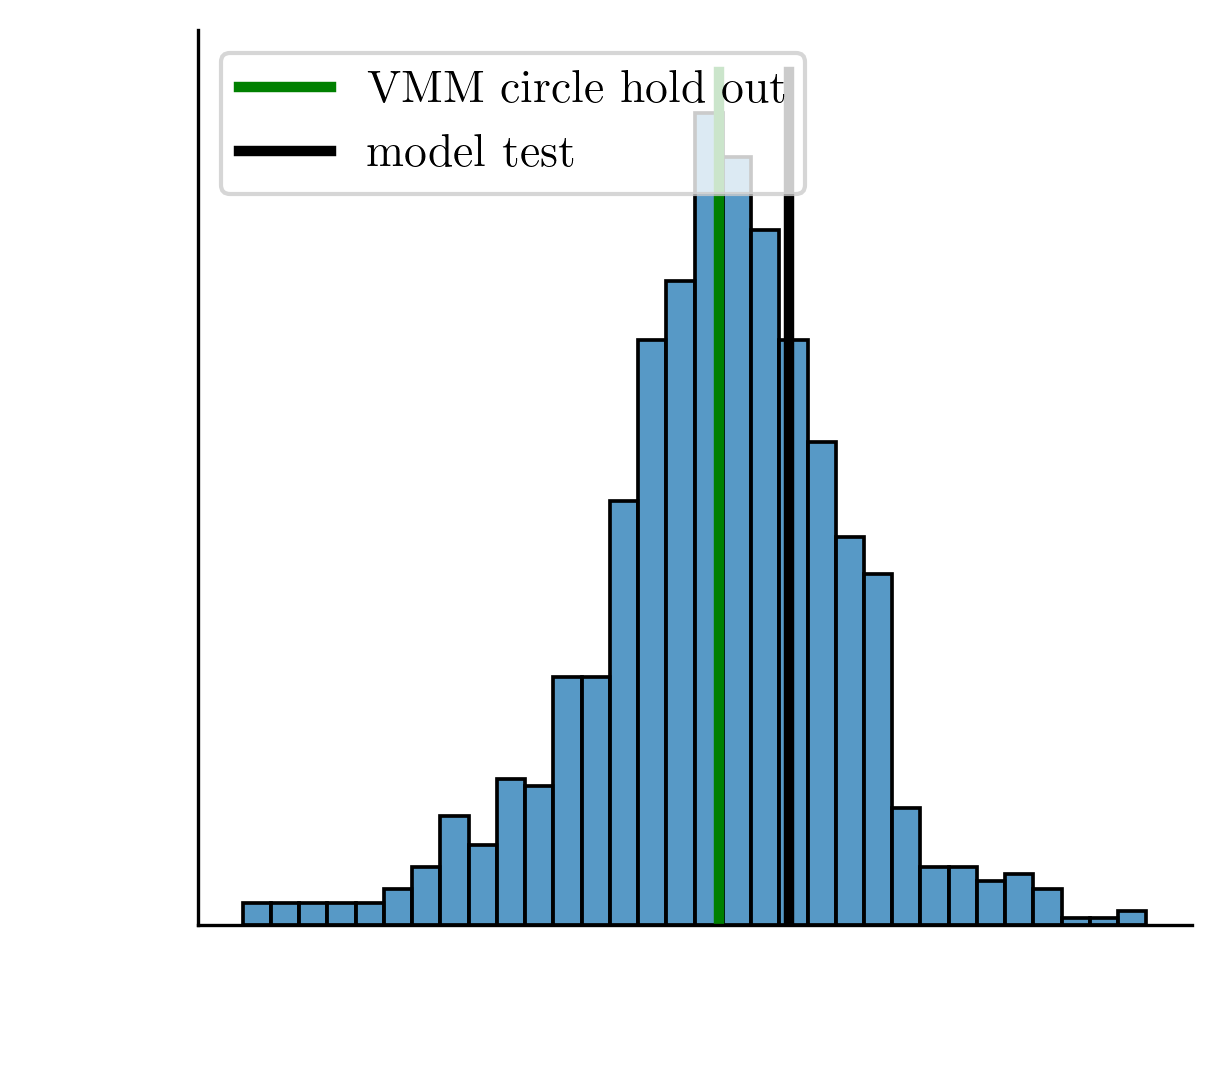

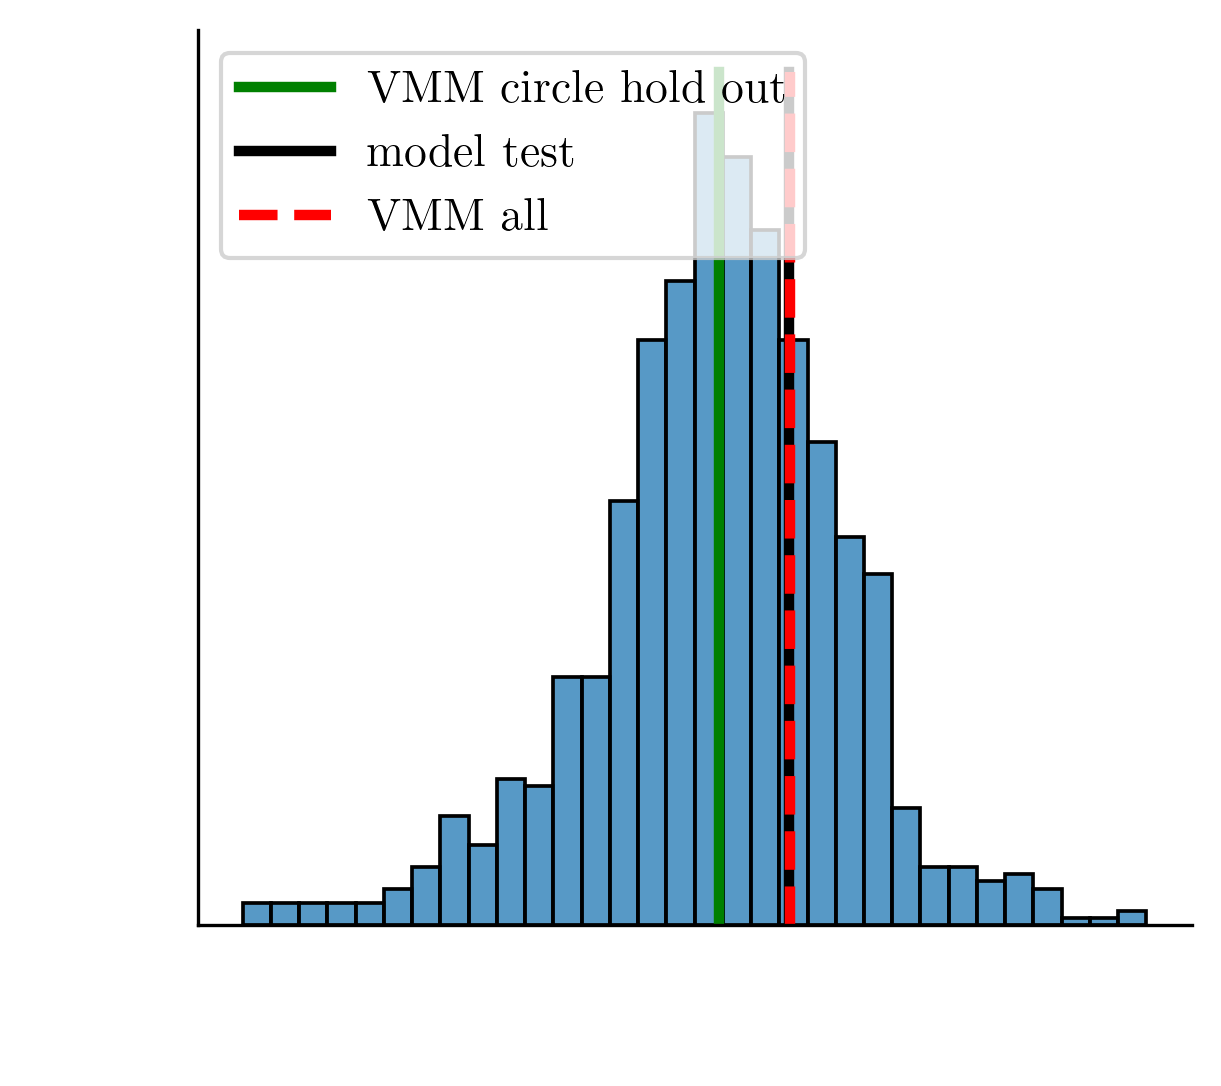

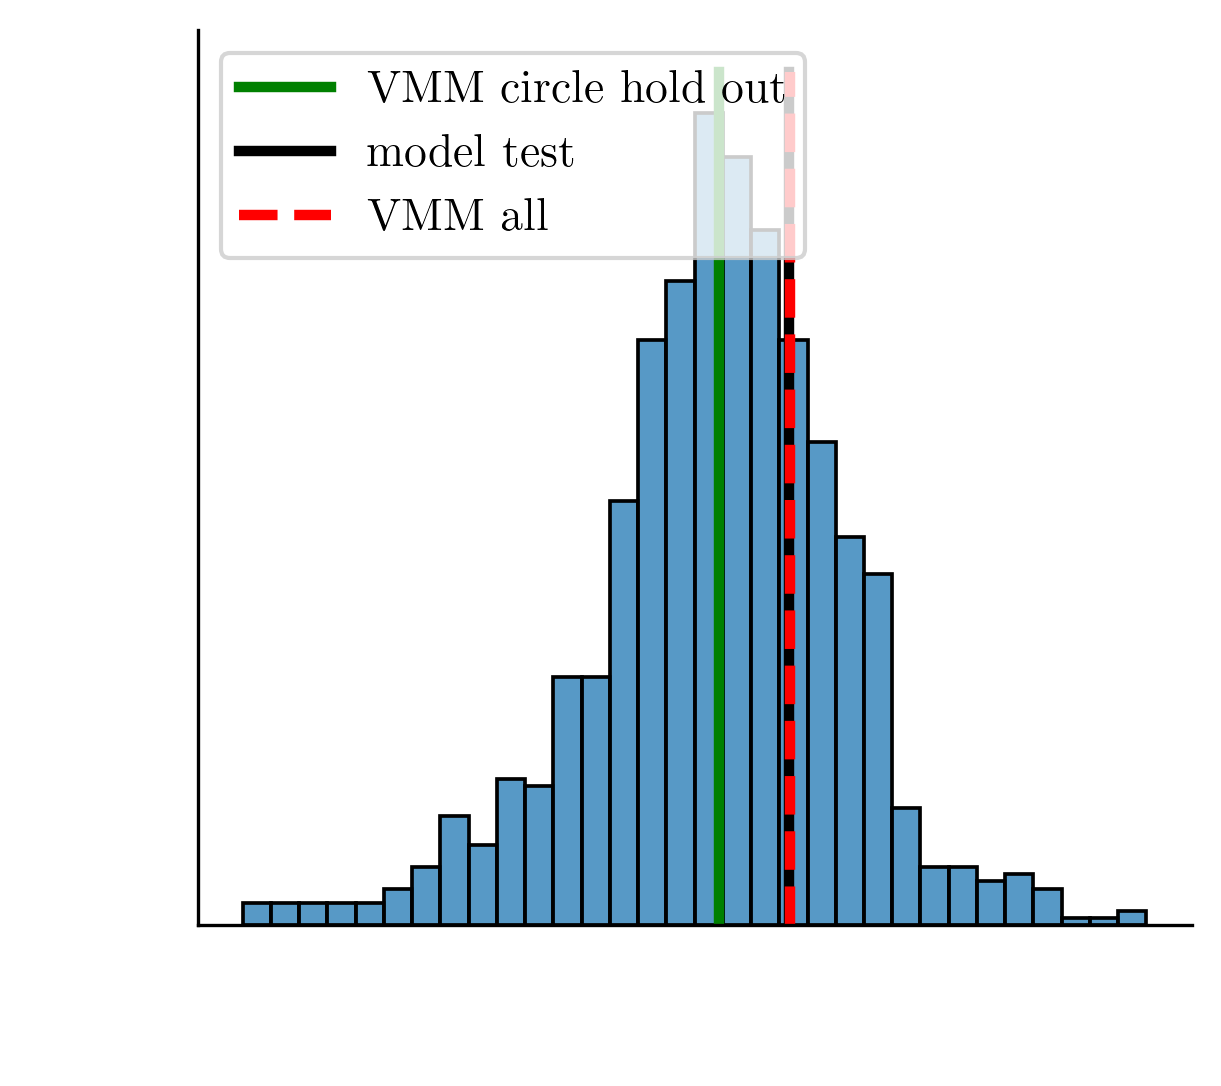

In [59]:
mask = ((df_turning_results['steady_turning_diameter'].quantile(0.001) < df_turning_results['steady_turning_diameter']) &
        (df_turning_results['steady_turning_diameter'].quantile(0.999) > df_turning_results['steady_turning_diameter']))

#fig,ax=plt.subplots()

df_turning_results.loc[mask].hist(column='steady_turning_diameter', bins=100, ax=ax)
grid = sns.displot(df_turning_results.loc[mask], x='steady_turning_diameter', stat="density")
ax = grid.fig.axes[0]
grid.fig.set_size_inches([0.5,0.7]*np.array(matplotlib.rcParams["figure.figsize"]))
ys = ax.get_ylim()

colors = ['g-','k-','r--']
for key in ['VMM circle hold out', 'model test', 'VMM all']:
    display(grid.fig)
    x = df_turning_results.loc[key, 'steady_turning_diameter']
    xs = [x,x]
    color = colors.pop(0)
    ax.plot(xs, ys, color, label=key, lw=2.5);

    ax.legend(loc='upper left');


fig = ax.get_figure()
fig_name = f"fig_monte-carlo_hist"
caption = f"Histogram of predicted steady turning diameter from Monte-Carlo simulations with parameter uncertainty for VMM fitted with turning circle as hold out. Also showing result from model test and VMM fitted on all data"
glue(fig_name, fig, display=False)

In [60]:
rv = norm(loc=df_turning_results['steady_turning_diameter'].mean(), scale=df_turning_results['steady_turning_diameter'].std())
intervalls = []
alphas = [0.99, 0.95, 0.75, 0.50]
for alpha in alphas:
    intervalls.append(rv.interval(alpha=alpha))
    
df_intervalls = pd.DataFrame(intervalls, columns=['min','max'], index=alphas)
df_intervalls.index.name='alpha'
df_intervalls.to_csv('intervalls.csv')
glue_table(f"steady_turning_diameter_intervalls", df_intervalls)

min        max
alpha                      
0.99    4.672352  22.551066
0.95    6.809699  20.413719
0.75    9.619448  17.603970
0.50   11.270908  15.952510